In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors

import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

from definition.defPrincipal import *

%matplotlib inline

In [2]:
from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=6)
client = Client(cluster)
client

/home/durand/anaconda3/envs/croco/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: inproc://134.246.214.54/23167/1 Dashboard: http://134.246.214.54:40671/status,Cluster Workers: 1 Cores: 6 Memory: 33.67 GB


In [3]:
def _adjust_grid(ds):
        # relevant to regular/analytical grid for now
        #
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])
        
        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})
                
        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 
        
        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','eta').replace('nav_lon','xi')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='m', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )
        # Create xgcm grid
        coords={'xi':{'center':'x_rho', 'inner':'x_u'}, 
                'eta':{'center':'y_rho', 'inner':'y_v'}, 
                's':{'center':'s_rho', 'outer':'s_w'}}
        ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords)
        
        return ds

In [4]:
zarr_dir = '/media/durand/Gigatl/giga_2004a2014_mean/'
#V = ds.data_vars
V = ['zeta', 'u', 'v','rho']
datasets = []
for v in V:
    ds = xr.open_zarr(zarr_dir+'%s.zarr'%(v))
    datasets.append(ds)
ds = xr.merge(datasets)
ds

<xarray.Dataset>
Dimensions:      (s_rho: 50, x_rho: 1502, x_u: 1501, x_v: 1502, y_rho: 2002, y_u: 2002, y_v: 2001)
Coordinates:
    nav_lat_rho  (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    nav_lon_rho  (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    nav_lat_u    (y_u, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    nav_lon_u    (y_u, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
  * s_rho        (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    nav_lat_v    (y_v, x_v) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    nav_lon_v    (y_v, x_v) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
Dimensions without coordinates: x_rho, x_u, x_v, y_rho, y_u, y_v
Data variables:
    zeta         (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    u            (s_rho, y_u, x_u) float32 dask.array<chunksize=(1, 2002, 1501), meta=np.ndarray>
    v            (s_rho, y_v, x_v) float32 dask.array<chunksize=(1, 2001, 1502), meta=np.ndarray>
    rho          (s_rho, y_rho, x_rho) float32 dask.array<chunksize=(1, 2002, 1502), meta=np.ndarray>

In [5]:
# On ajoute dans le dataset les paramètres de grille qui sont dans le 1ier fichier
path="/media/durand/Gigatl/data/"
gridname = path+'GIGATL6_12h_inst_2004-01-15-2004-01-19.nc'
gd = xr.open_dataset(gridname, chunks={'s_rho': 1})
ds['hc'] = gd.hc
ds['h'] = gd.h
ds['Vtransform'] = gd.Vtransform
ds['sc_r'] = gd.sc_r
ds['sc_w'] = gd.sc_w
ds['Cs_r'] = gd.Cs_r
ds['Cs_w'] = gd.Cs_w
ds['angle'] = gd.angle
ds['mask_rho'] = gd.mask_rho

In [6]:
# On modifie des dimensions et des coordonnées, on crée la grille xgcm
ds = _adjust_grid(ds)
L = ds.dims['x_rho']
M = ds.dims['y_rho']
N = ds.dims['s_rho']
#ds = ds.chunk({'s_rho': 1, 's_w':1, 'x_rho':1000, 'x_u':1000, 'y_rho':1000, 'y_v':1000})
#ds = ds.chunk({'s_rho': 1, 's_w':1, 'x_rho':1, 'x_u':1})
ds

<xarray.Dataset>
Dimensions:     (s_rho: 50, s_w: 51, x_rho: 1502, x_u: 1501, y_rho: 2002, y_v: 2001)
Coordinates:
    eta_rho     (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_rho      (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    eta_u       (y_rho, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    xi_u        (y_rho, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
  * s_rho       (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    eta_v       (y_v, x_rho) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    xi_v        (y_v, x_rho) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
  * s_w         (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
Dimensions without coordinates: x_rho, x_u, y_rho, y_v
Data variables:
    zeta        (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    u           (s_rho, y_rho, x_u) float32 dask.array<chunksize=(1, 2002, 1501), meta=np.ndarray>
    v           (s_rho, y_v, x_rho) float32 dask.array<chunksize=(1, 2001, 1502), meta=np.ndarray>
    rho         (s_rho, y_rho, x_rho) float32 dask.array<chunksize=(1, 2002, 1502), meta=np.ndarray>
    hc          float32 ...
    h           (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Cs_r        (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_w        (s_w) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    angle       (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    mask_rho    (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
Attributes:
    xgcm-Grid:  <xgcm.Grid>\nxi Axis (periodic):\n  * center   x_rho --> inne...

In [7]:
# On crée la grille xgcm
ds = xgcm_grid(ds)
grid = ds.attrs['xgcm-Grid']

In [8]:
%%time
# Compute depth at rho point
z = get_z(ds,zeta=ds['zeta'],hgrid='r').compute()

/home/durand/croco/progForPaper/Part_1/definition/defPrincipal.py:138: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(*(zdim,)+_zeta.dims)


CPU times: user 4.61 s, sys: 570 ms, total: 5.18 s
Wall time: 1.41 s


In [9]:
%%time
# get u at rho point
[urot,vrot] = rotuv(ds)
u=urot.compute()


elaps is : 0.09125684600076056
elaps is : 0.1809337279992178
CPU times: user 7.67 s, sys: 1.04 s, total: 8.72 s
Wall time: 8.69 s


In [10]:
rho=ds.rho+1027.4-1000
rho=rho.compute()

<xarray.DataArray (y_rho: 2002, x_rho: 1502)>
dask.array<mul, shape=(2002, 1502), dtype=float64, chunksize=(2002, 1502), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  (y_rho, x_rho) float32 -53.601315 -53.618214 ... 65.46343 65.42858
    xi_rho   (y_rho, x_rho) float32 -73.286835 -73.21415 ... 27.078564 27.151964
    s_rho    (y_rho, x_rho) float64 -0.99 -0.99 -0.99 ... -0.99 -0.99 -0.99
Dimensions without coordinates: y_rho, x_rho
level = [-0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16]
CPU times: user 1.98 s, sys: 340 ms, total: 2.32 s
Wall time: 2.28 s


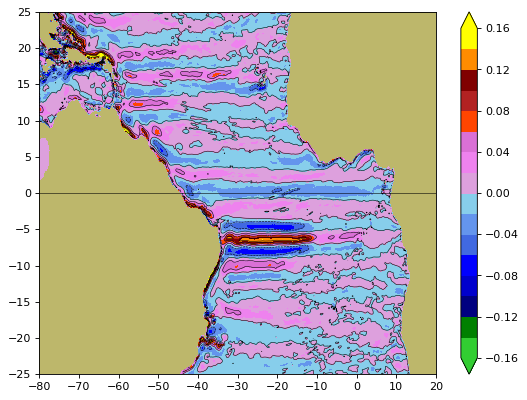

In [17]:
%%time
# plot slice depth
depth=-1000.
vnew= slice(ds,u,z,depth=depth)


plt.figure(figsize=(8,6), dpi=80)

cmap = colors.ListedColormap(['limegreen','green','navy','mediumblue','blue','royalblue','cornflowerblue','skyblue','plum','violet','orchid','orangered','firebrick','maroon','darkorange','yellow'])
boundaries = np.linspace(-0.16, 0.16, 17)
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

print(vnew)
vnew.plot(x=[s for s in u.coords if "xi_" in s][0],
                       y=[s for s in u.coords if "eta_" in s][0],
                       #vmin=1027, vmax=1028., 
                       xlim=[-80.,20],
                       ylim=[-25.,25.],
                       levels=17,
                       cmap=cmap,norm=norm
                       )

levels=np.linspace(-0.16, 0.16, 9)
print('level =',levels)

vnew.plot.contour(x=[s for s in u.coords if "xi_" in s][0],
                  y=[s for s in u.coords if "eta_" in s][0],
                  levels=np.linspace(-0.16, 0.16, 9),
                  colors='black',
                  linewidths=0.5)

ax = plt.gca()
ax.set_facecolor('darkkhaki')
axisx=np.linspace(-80, 20, 11)
axisy=np.linspace(-25, 25, 11)
ax.xaxis.set_ticks(axisx)
ax.yaxis.set_ticks(axisy)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.axhline(y=0.,color='black',linewidth=0.5)


In [12]:
# depth=-1000.
# vnew= slice(ds,rho,z,depth=depth)

# plt.figure(figsize=(8,6), dpi=80)

# vnew.plot(x=[s for s in u.coords if "xi_" in s][0],
#                        y=[s for s in u.coords if "eta_" in s][0],
#                        vmin=27.42,vmax=27.46 ,
#                        xlim=[-80.,20],
#                        ylim=[-25.,25.],
#                        levels=11,
#                        )

# vnew.plot.contour(x=[s for s in u.coords if "xi_" in s][0],
#                   y=[s for s in u.coords if "eta_" in s][0],
#                   levels=np.linspace(27.42, 27.46, 6),
#                   colors='black')

# ax = plt.gca()
# axisx=np.linspace(-80, 20, 11)
# axisy=np.linspace(-25, 25, 11)
# ax.xaxis.set_ticks(axisx)
# ax.yaxis.set_ticks(axisy)
# plt.axhline(y=0.,color='black',linewidth=0.5)
# ax.set_facecolor('darkkhaki')

In [13]:
# cluster.close()